**使用CNN处理文本**

In [2]:
import torch
from torch import nn
from d2l import torch as d2l
from net_frame import *
from tqdm import tqdm

**一、数据预处理**

In [8]:
from data_preprocess import *
train_iter,test_iter,vocab = get_data()

read pos:   0%|          | 0/12500 [00:00<?, ?it/s]

read neg: 100%|██████████| 12500/12500 [00:00<00:00, 49026.32it/s]


Load raw data use time:0.5917714992538095s


read neg: 100%|██████████| 12500/12500 [00:00<00:00, 47873.76it/s]


Load raw data use time:0.5575972925871611s
Build vocab....
Finish!
Build data-iter...
Finish!


**二、搭建textCNN模型**

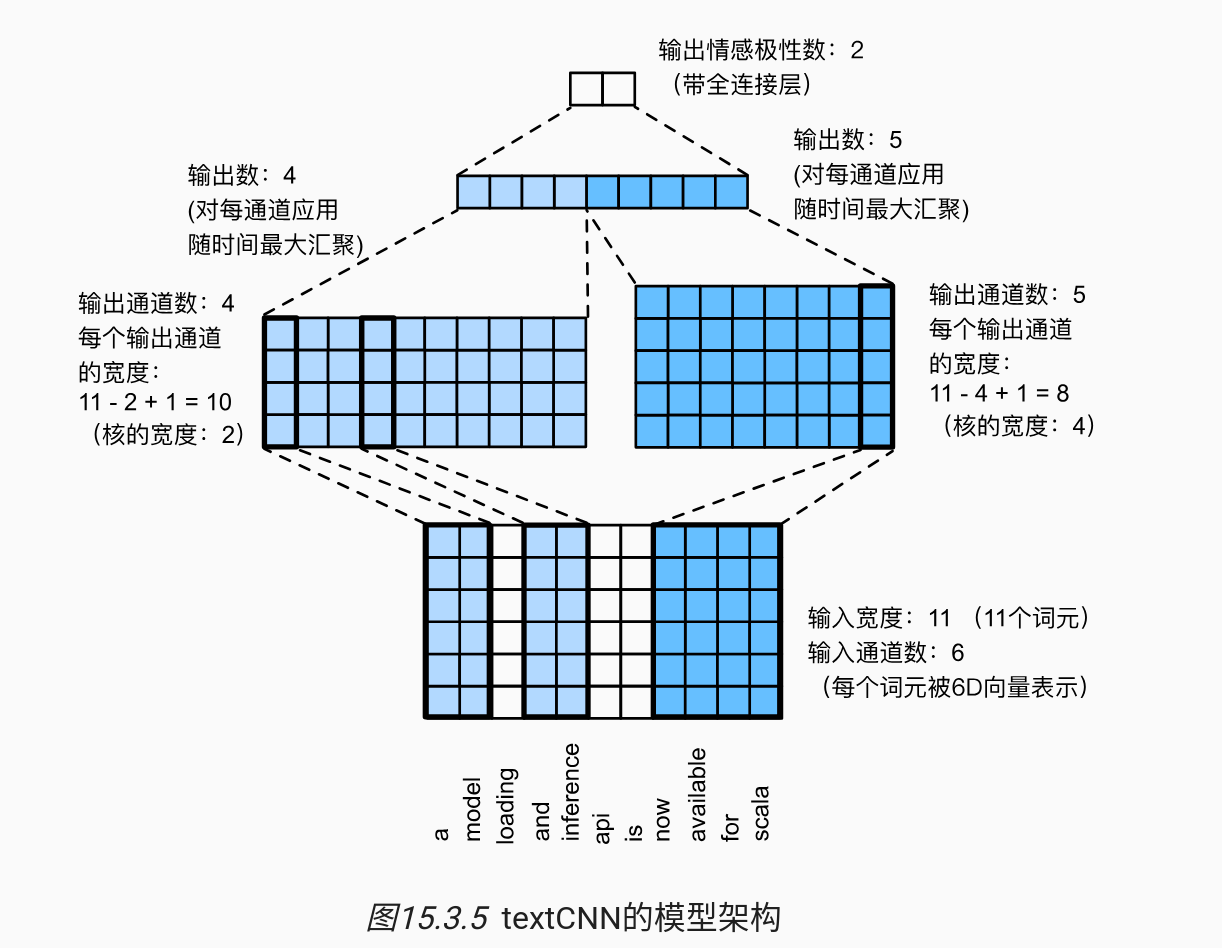

In [4]:
# 定义模型
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels,
                 **kwargs):
        super(TextCNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # 这个嵌入层不需要训练
        self.constant_embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(sum(num_channels), 2)
        # 最大时间汇聚层没有参数，因此可以共享此实例
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.relu = nn.ReLU()
        # 创建多个一维卷积层
        self.convs = nn.ModuleList()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(2 * embed_size, c, k))

    def forward(self, inputs):
        # 沿着向量维度将两个嵌入层连结起来，
        # 每个嵌入层的输出形状都是（批量大小，词元数量，词元向量维度）连结起来
        embeddings = torch.cat((
            self.embedding(inputs), self.constant_embedding(inputs)), dim=2)
        # 根据一维卷积层的输入格式，重新排列张量，以便通道作为第2维
        embeddings = embeddings.permute(0, 2, 1)
        # 每个一维卷积层在最大时间汇聚层合并后，获得的张量形状是（批量大小，通道数，1）
        # 删除最后一个维度并沿通道维度连结
        encoding = torch.cat([
            torch.squeeze(self.relu(self.pool(conv(embeddings))), dim=-1)
            for conv in self.convs], dim=1) # cuijunjie:最后得到(batch_size,channels)
        outputs = self.decoder(self.dropout(encoding))
        return outputs

In [38]:
embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [100, 100, 100]
net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)

def init_weights(m):
    if type(m) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

TextCNN(
  (embedding): Embedding(76835, 100)
  (constant_embedding): Embedding(76835, 100)
  (dropout): Dropout(p=0.5, inplace=False)
  (decoder): Linear(in_features=300, out_features=2, bias=True)
  (pool): AdaptiveAvgPool1d(output_size=1)
  (relu): ReLU()
  (convs): ModuleList(
    (0): Conv1d(200, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(200, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(200, 100, kernel_size=(5,), stride=(1,))
  )
)

In [ ]:
# 预先练embedding层
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]

In [39]:
net.embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.requires_grad = False

In [40]:
from torchinfo import summary
input = torch.ones((64,500),dtype = torch.long)
print(summary(net,input_data = input))

Layer (type:depth-idx)                   Output Shape              Param #
TextCNN                                  [64, 2]                   --
├─Embedding: 1-1                         [64, 500, 100]            7,683,500
├─Embedding: 1-2                         [64, 500, 100]            (7,683,500)
├─ModuleList: 1-9                        --                        (recursive)
│    └─Conv1d: 2-1                       [64, 100, 498]            60,100
├─AdaptiveAvgPool1d: 1-4                 [64, 100, 1]              --
├─ReLU: 1-5                              [64, 100, 1]              --
├─ModuleList: 1-9                        --                        (recursive)
│    └─Conv1d: 2-2                       [64, 100, 497]            80,100
├─AdaptiveAvgPool1d: 1-7                 [64, 100, 1]              --
├─ReLU: 1-8                              [64, 100, 1]              --
├─ModuleList: 1-9                        --                        (recursive)
│    └─Conv1d: 2-3                

In [41]:
# 计算准确率
def accurancy(net,data_iter,device):
    """计算准确率"""
    net.eval()
    total_nums = 0
    correct_nums = 0
    for batch in data_iter:
        X,Y = batch[0],batch[1]
        X = X.to(device)
        Y = Y.to(device)
        y_pred = net(X).argmax(dim = 1)
        correct_nums += (y_pred == Y).sum().item()
        total_nums += X.shape[0]
    return correct_nums / total_nums

# 定义训练函数
def train(net,trainer:torch.optim.Adam,train_iter,test_iter,loss_fn,lr,num_epochs,device_idx = None):
    """训练情感分析模型"""
    # 设置设备
    if device_idx == None:
        device = try_gpu(i = 0)
    else:
        device = try_gpu(device_idx)
    
    # 加载网络
    net = net.to(device)

    # 开始训练
    loss_plt = []
    train_accs = []
    test_accs = []
    for epoch in range(num_epochs):
        net.train() # 循环涉及评估，则每次循环前要net.train()
        loop = tqdm(train_iter,desc = f"Epoch:[{epoch + 1}/{num_epochs}]",
                    total = len(train_iter))
        loss_temp = 0
        total_nums = 0
        for batch in loop:
            # 清空梯度
            trainer.zero_grad()

            # forward
            X,Y = batch
            X = X.to(device)
            Y = Y.to(device)
            # print(X.shape,Y.shape)
            y_pred = net(X)
            total_nums += X.shape[0]

            # count loss and backwar
            loss = loss_fn(y_pred,Y)
            loss.sum().backward()
            trainer.step()

            # 先step后再调用item()，否则切断计算图
            loss_temp += loss.sum().item()
            
            # # update parameters
            # trainer.step()
            loop.set_postfix({"LOSS" : loss_temp / total_nums,"lr" : "{:e}".format(trainer.param_groups[0]['lr'])})
        print("Counting accurancy...")
        train_acc = accurancy(net,train_iter,device)
        test_acc = accurancy(net,test_iter,device)
        print(f"train acc:{train_acc}")
        print(f"test acc:{test_acc}")
        loss_plt.append(loss_temp / total_nums)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
    return loss_plt,train_accs,test_accs

In [42]:
# 训练超参数
lr, num_epochs = 0.001, 20
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
plt_collections = train(net,trainer,train_iter,test_iter,loss,lr,num_epochs,device_idx = 7)

Epoch:[1/20]:   0%|          | 0/391 [00:00<?, ?it/s, LOSS=0.688, lr=1.000000e-03]

Epoch:[1/20]: 100%|██████████| 391/391 [00:02<00:00, 134.12it/s, LOSS=0.521, lr=1.000000e-03]


Counting accurancy...
train acc:0.87788
test acc:0.83852


Epoch:[2/20]: 100%|██████████| 391/391 [00:04<00:00, 97.00it/s, LOSS=0.279, lr=1.000000e-03]


Counting accurancy...
train acc:0.94452
test acc:0.87804


Epoch:[3/20]: 100%|██████████| 391/391 [00:04<00:00, 97.09it/s, LOSS=0.169, lr=1.000000e-03]


Counting accurancy...
train acc:0.97452
test acc:0.88124


Epoch:[4/20]: 100%|██████████| 391/391 [00:03<00:00, 97.90it/s, LOSS=0.0975, lr=1.000000e-03]


Counting accurancy...
train acc:0.98752
test acc:0.87464


Epoch:[5/20]: 100%|██████████| 391/391 [00:03<00:00, 103.79it/s, LOSS=0.0524, lr=1.000000e-03]


Counting accurancy...
train acc:0.98716
test acc:0.85752


Epoch:[6/20]: 100%|██████████| 391/391 [00:03<00:00, 103.79it/s, LOSS=0.0309, lr=1.000000e-03]


Counting accurancy...
train acc:0.9928
test acc:0.8662


Epoch:[7/20]: 100%|██████████| 391/391 [00:03<00:00, 98.74it/s, LOSS=0.0181, lr=1.000000e-03]


Counting accurancy...
train acc:0.999
test acc:0.8712


Epoch:[8/20]: 100%|██████████| 391/391 [00:03<00:00, 99.57it/s, LOSS=0.0093, lr=1.000000e-03] 


Counting accurancy...
train acc:0.99956
test acc:0.86904


Epoch:[9/20]: 100%|██████████| 391/391 [00:03<00:00, 99.39it/s, LOSS=0.00654, lr=1.000000e-03]


Counting accurancy...
train acc:0.99492
test acc:0.85772


Epoch:[10/20]: 100%|██████████| 391/391 [00:03<00:00, 102.42it/s, LOSS=0.00468, lr=1.000000e-03]


Counting accurancy...
train acc:0.99992
test acc:0.86616


Epoch:[11/20]: 100%|██████████| 391/391 [00:03<00:00, 100.18it/s, LOSS=0.00461, lr=1.000000e-03]


Counting accurancy...
train acc:0.99992
test acc:0.86412


Epoch:[12/20]: 100%|██████████| 391/391 [00:03<00:00, 111.92it/s, LOSS=0.00356, lr=1.000000e-03]


Counting accurancy...
train acc:0.99996
test acc:0.86656


Epoch:[13/20]: 100%|██████████| 391/391 [00:03<00:00, 100.67it/s, LOSS=0.0155, lr=1.000000e-03]


Counting accurancy...
train acc:0.99708
test acc:0.84572


Epoch:[14/20]: 100%|██████████| 391/391 [00:03<00:00, 99.16it/s, LOSS=0.0103, lr=1.000000e-03] 


Counting accurancy...
train acc:0.99188
test acc:0.83728


Epoch:[15/20]: 100%|██████████| 391/391 [00:03<00:00, 98.75it/s, LOSS=0.00225, lr=1.000000e-03]


Counting accurancy...
train acc:0.99992
test acc:0.86284


Epoch:[16/20]: 100%|██████████| 391/391 [00:03<00:00, 98.11it/s, LOSS=0.00194, lr=1.000000e-03] 


Counting accurancy...
train acc:0.99996
test acc:0.86368


Epoch:[17/20]: 100%|██████████| 391/391 [00:03<00:00, 98.17it/s, LOSS=0.00512, lr=1.000000e-03] 


Counting accurancy...
train acc:0.99972
test acc:0.86168


Epoch:[18/20]: 100%|██████████| 391/391 [00:03<00:00, 98.22it/s, LOSS=0.00673, lr=1.000000e-03] 


Counting accurancy...
train acc:0.99992
test acc:0.85856


Epoch:[19/20]: 100%|██████████| 391/391 [00:03<00:00, 98.70it/s, LOSS=0.0126, lr=1.000000e-03]  


Counting accurancy...
train acc:0.99992
test acc:0.86028


Epoch:[20/20]: 100%|██████████| 391/391 [00:04<00:00, 97.70it/s, LOSS=0.00478, lr=1.000000e-03]


Counting accurancy...
train acc:0.99968
test acc:0.85484


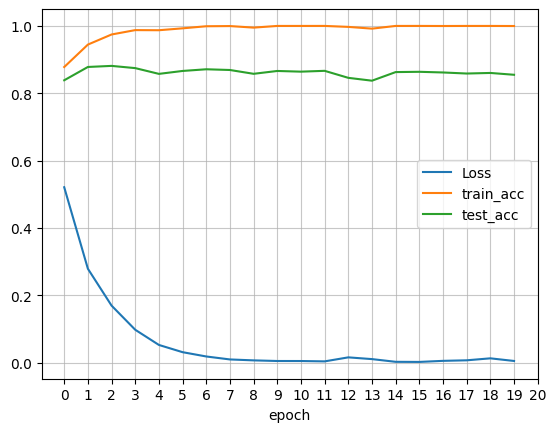

In [43]:
import matplotlib.pyplot as plt
import numpy as np
loss_plt,train_acc_plt,test_acc_plt = plt_collections
plt.plot(np.arange(num_epochs),loss_plt,label = 'Loss')
plt.plot(np.arange(num_epochs),train_acc_plt,label = 'train_acc')
plt.plot(np.arange(num_epochs),test_acc_plt,label = 'test_acc')
plt.xlabel("epoch")

# 设置主要和次要刻度
plt.xticks(np.arange(0, num_epochs + 1, 1))  # 主刻度每1单位
plt.yticks(np.arange(0, 1.1, 0.2))  # Y轴每0.5单位

# 添加主要网格和次要网格
plt.grid(True, which='major', linestyle='-', alpha=0.7)
plt.legend()
plt.show()

In [44]:
import os
save_prefix = "results/cnn"
os.makedirs(save_prefix,exist_ok = True)
torch.save(net,os.path.join(save_prefix,"exp2.pt"))

In [45]:
# 保存结果数据
import joblib
plot_prefix = "plots/cnn"
os.makedirs(plot_prefix,exist_ok = True)
joblib.dump(plt_collections,os.path.join(plot_prefix,"exp2-20epoch.joblib"))

['plots/cnn/exp2-20epoch.joblib']

**三、模型评估**

In [5]:
net = torch.load("results/cnn/exp1.pt")

/tmp/ipykernel_1704785/522049972.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net = torch.load("results/cnn/exp1.pt")


In [6]:
def predict(input,vocab:Vocab,net):
    net.eval()
    device = next(net.parameters()).device
    input = [vocab[word] for word in input.split()]
    input = torch.tensor(
        truncate_pad(input,num_steps = 500,padding_token = vocab['<pad>'])).unsqueeze(0) 
    # shape = (batch_size,num_steps)
    y_pred = torch.argmax(net(input.to(device)),dim = 1).squeeze(0).item()
    return "positive" if y_pred == 1 else "negative"
    

In [9]:
print(predict("the movie is bad",vocab,net))
print(predict("the movie is good",vocab,net))
print(predict("this movie is so great",vocab,net))
print(predict("I'm a male, not given to women's movies, but this is really a well done special story. I have no personal love for Jane Fonda as a person but she does one Hell of a fine job, while DeNiro is his usual superb self. Everything is so well done: acting, directing, visuals, settings, photography, casting. If you can enjoy a story of real people and real love - this is a winner.",vocab,net))

negative
positive
positive
positive


In [10]:
print(predict("good",vocab,net))
print(predict("Bad",vocab,net))
print(predict("fantastic",vocab,net))

negative
negative
positive
